In [25]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

In [12]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
OptimalXAI

array([[ 0, 47],
       [ 1, 37],
       [ 2,  8],
       [ 3, 43],
       [ 4, 45],
       [ 5, 43],
       [ 6,  8],
       [ 7,  8]])

### Train NN with all relevant features

For this, we need one-hot encoded y

In [13]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 8, 43, 45, 47}
(5251, 5)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


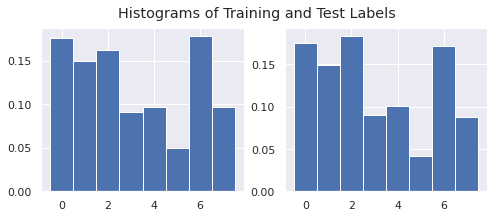

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [15]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

5 8
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1536      
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1024)              132096    
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 8)            

In [16]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 19ms/step - loss: 2.0500 - accuracy: 0.1893 - val_loss: 2.0217 - val_accuracy: 0.1717
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 1.9952 - accuracy: 0.1870 - val_loss: 1.9661 - val_accuracy: 0.1717
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 1.9345 - accuracy: 0.1904 - val_loss: 1.9078 - val_accuracy: 0.1859
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 1.8787 - accuracy: 0.2177 - val_loss: 1.8418 - val_accuracy: 0.2371
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 1.8069 - accuracy: 0.3007 - val_loss: 1.7555 - val_accuracy: 0.3366
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 1.7209 - accuracy: 0.3565 - val_loss: 1.6546 - val_accuracy: 0.3695
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 1.6196 - accuracy: 0.4019 - val_loss: 1.5419 - val_accuracy: 0.4252
Epoch 8/100


In [17]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.8061165608770917


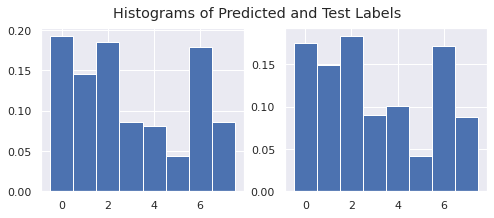

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Now with some other features

In [19]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [20]:
TestNN(54321)

0.7241777264858626

In [21]:
TestNN()

0.7380265435660704

In [22]:
Runs = 100
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [5206] 0.6370455856895557
1 [8676] 0.6624350836699365
2 [2446] 0.7743796884016156
3 [2594] 0.6687824581650318
4 [0] 0.6203115983843047
5 [7221] 0.7316791690709752
6 [6887] 0.7784189267166762
7 [7580] 0.7461050201961916
8 [30] 0.6064627813040969
9 [7699] 0.6485862665897288
10 [4222] 0.8228505481823427
11 [6242] 0.7784189267166762
12 [1070] 0.7351413733410271
13 [6397] 0.8015002885170225
14 [7177] 0.6832083092902481
15 [2956] 0.7478361223312175
16 [395] 0.7512983266012695
17 [5141] 0.6895556837853434
18 [8748] 0.6780150028851702
19 [6897] 0.7766878245816503
20 [5977] 0.676860934795153
21 [5705] 0.7743796884016156
22 [4016] 0.6658972879399885
23 [2914] 0.7512983266012695
24 [142] 0.7934218118869013
25 [657] 0.8130409694171956
26 [9479] 0.8430467397576457
27 [4210] 0.7057126370455857
28 [8513] 0.7189844200807848
29 [9173] 0.7864974033467974
30 [9637] 0.7501442585112522
31 [6801] 0.8343912290825158
32 [3333] 0.7864974033467974
33 [921] 0.6532025389497981
34 [1677] 0.6601269474899019
35 [5

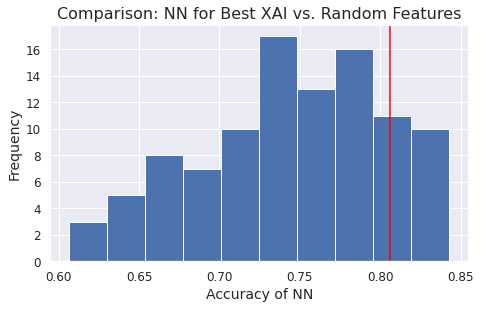

In [34]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NN",dpi=600)
plt.show()

In [24]:
np.median(NN_comparison),np.mean(NN_comparison), Accuracy_BestXAI

(0.7489901904212348, 0.744068090017311, 0.8061165608770917)